In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import elu
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import cohen_kappa_score


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [2]:
TRAIN_DATA_PATH = './data/train_images/'
TEST_DATA_PATH = './data/test_images/'

In [3]:
# Image properties

IMG_WIDTH = 299
IMG_HEIGHT = 299

In [4]:
# Hyperparameters

BATCH_SIZE = 32

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
df_train['id_code'] = df_train['id_code'] + '.png'
df_test['id_code'] = df_test['id_code'] + '.png'

In [7]:
df_train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [8]:
df_test.head()

,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


In [18]:
def get_preds_and_labels(model, generator):
    preds = []
    labels = []
    
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
        
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [9]:
def preprocess_image(path):
    img = cv2.imread(df_train['id_code'][0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    return img
    

In [10]:
# Data generator

data_generator = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split=0.15)

train_generator = data_generator.flow_from_dataframe(df_train,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    directory = TRAIN_DATA_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other',
                                                    preprocessing_function = preprocess_image,
                                                    subset='training')

val_generator = data_generator.flow_from_dataframe(df_train,
                                                  x_col='id_code',
                                                  y_col='diagnosis',
                                                  directory = TRAIN_DATA_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size = BATCH_SIZE,
                                                  class_mode='other',
                                                  preprocessing_function = preprocess_image,
                                                  subset='validation')



Found 3113 validated image filenames.
Found 549 validated image filenames.


In [11]:
# Build model

xception_model = Xception(weights=None, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()
model.add(xception_model)

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(5, activation=elu))
model.add(Dense(1, activation="linear"))

In [12]:
# Compilation 

model.compile(loss='mse', optimizer=Adam(0.0001), metrics=['mse', 'acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 20,871,731
Trainable params: 20,817,203
Non-trainable params: 54,528
_________________________________________________________________


In [13]:
# Training

history = model.fit_generator(train_generator,
                   steps_per_epoch = train_generator.samples // BATCH_SIZE,
                   epochs=40,
                   validation_data = val_generator,
                   validation_steps = val_generator.samples // BATCH_SIZE)


Epoch 1/40
97/97 [==============================] - 342s 4s/step - loss: 1.1937 - mse: 1.1804 - acc: 0.3765 - val_loss: 2.7831 - val_mse: 2.7831 - val_acc: 0.4577
Epoch 2/40
97/97 [==============================] - 333s 3s/step - loss: 0.9169 - mse: 0.9132 - acc: 0.4206 - val_loss: 2.4062 - val_mse: 2.4062 - val_acc: 0.4577
Epoch 3/40
97/97 [==============================] - 329s 3s/step - loss: 0.8349 - mse: 0.8402 - acc: 0.4609 - val_loss: 1.9949 - val_mse: 1.9949 - val_acc: 0.1029
Epoch 4/40
97/97 [==============================] - 327s 3s/step - loss: 0.7915 - mse: 0.7920 - acc: 0.4719 - val_loss: 1.7214 - val_mse: 1.7214 - val_acc: 0.1029
Epoch 5/40
97/97 [==============================] - 324s 3s/step - loss: 0.7577 - mse: 0.7578 - acc: 0.4950 - val_loss: 1.7187 - val_mse: 1.7187 - val_acc: 0.1029
Epoch 6/40
97/97 [==============================] - 320s 3s/step - loss: 0.7255 - mse: 0.7263 - acc: 0.5011 - val_loss: 1.7150 - val_mse: 1.7150 - val_acc: 0.1029
Epoch 7/40
97/97 [====

In [14]:
# Save model

model.save('xception_model.h5')

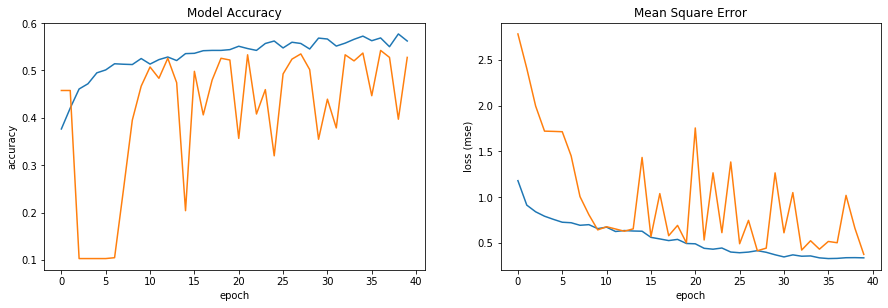

In [16]:
# Show metrics

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(222)
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Square Error')
plt.ylabel('loss (mse)')
plt.xlabel('epoch')


plt.show()


In [17]:
# Load model

#model.load_weights('xception_model.h5')

In [21]:
# Calculate QWK on train set

y_train_preds, train_labels = get_preds_and_labels(model, train_generator)
y_train_preds = np.rint(y_train_preds).astype(np.uint8).clip(0, 4)

In [23]:
# Calculate the score
train_score = cohen_kappa_score(train_labels, y_train_preds, weights="quadratic")

In [24]:
# Calculate QWK on validation set

y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(0,4)

In [26]:
# Calculate the score
val_score = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

In [28]:
print("Cohen Kappa Score (train): {:.4f}".format(train_score))
print("Cohen Kappa Score (validation): {:.4f}".format(val_score))

Cohen Kappa Score (train): 0.8952
Cohen Kappa Score (validation): 0.8573


In [ ]:
# TODO: Optimize on validation data